## 1. Setup and Data Loading

In [2]:
%load_ext autoreload
%autoreload 2

# Enable interactive matplotlib for 3D visualization
# %matplotlib widget

from pathlib import Path
import sys
sys.path.append(str(Path("..")))

# Import required modules
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import project modules
from src.utils.config import load_config
from src.data.cvat_loader import CVATLoader
from src.data.coco_loader import COCOLoader
from src.data.folder_loader import FolderLoader

# Set up matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All modules imported successfully!")

All modules imported successfully!


In [5]:
# Load configuration
# config = load_config(Path("../config.yaml"))
config_path = Path("../config.yaml")
config = load_config(config_path)
print(f"Configuration loaded from config.yaml")
print(f"Dataset: {config['dataset']['root_path']}")
print(f"Analysis method: {config['analysis']['method']}")

dataset_config = config['dataset']
dataset_root = ".."/Path(dataset_config['root_path'])
crop_to_bbox = dataset_config.get('crop_to_bbox', True)
dataset_format = dataset_config.get('format', 'cvat')  # Default to CVAT for backward compatibility

# Use images_dir to override root_path if provided
if 'images_dir' in dataset_config and dataset_config['images_dir']:
    image_root = Path(dataset_config['images_dir'])
    if not image_root.is_absolute():
        image_root = dataset_root / dataset_config['images_dir']
else:
    image_root = dataset_root

if dataset_format.lower() == 'coco':
    annotations_file = dataset_config['annotations_file']
    coco_json_path = dataset_root / annotations_file
    loader = COCOLoader(coco_json_path, image_root, crop_to_bbox=crop_to_bbox)
    print(f"Loaded COCO dataset: {len(loader)} annotations")
    print(f"Annotations from: {coco_json_path}")
    print(f"Images from: {image_root}")
elif dataset_format.lower() == 'cvat':
    loader = CVATLoader(dataset_root, crop_to_bbox=crop_to_bbox)
    print(f"Loaded CVAT dataset: {len(loader)} annotations")
    print(f"Dataset root: {dataset_root}")
elif dataset_format.lower() == 'folder':
    image_extensions = dataset_config.get('image_extensions', None)
    loader = FolderLoader(image_root, crop_to_bbox=crop_to_bbox, image_extensions=image_extensions)

annotations = loader.annotations.copy()

print(f"\nDataset loaded:")
print(f"  Total images: {len(annotations)}")
print(f"  Crop to bbox: {crop_to_bbox}")

# Show viewpoint distribution
viewpoints = [ann.viewpoint for ann in annotations]
unique_viewpoints, counts = np.unique(viewpoints, return_counts=True)
print(f"\nViewpoint distribution:")
for vp, count in zip(unique_viewpoints, counts):
    print(f"  {vp}: {count} images")

Configuration loaded from config.yaml
Dataset: D:/work/tech4conservation/GiantAnteaterdataset
Analysis method: kmeans

Dataset loaded:
  Total images: 2866
  Crop to bbox: False

Viewpoint distribution:
  unknown: 2866 images


In [16]:
from src.pipeline.animal_detection_pipeline import create_pipeline_from_main_config

print(config_path)
pipeline = create_pipeline_from_main_config(config_path)

..\config.yaml


Using cache found in C:\Users\Ted/.cache\torch\hub\facebookresearch_dinov2_main


Cluster labels loaded from ..\cluster_labels_anteater_s.json


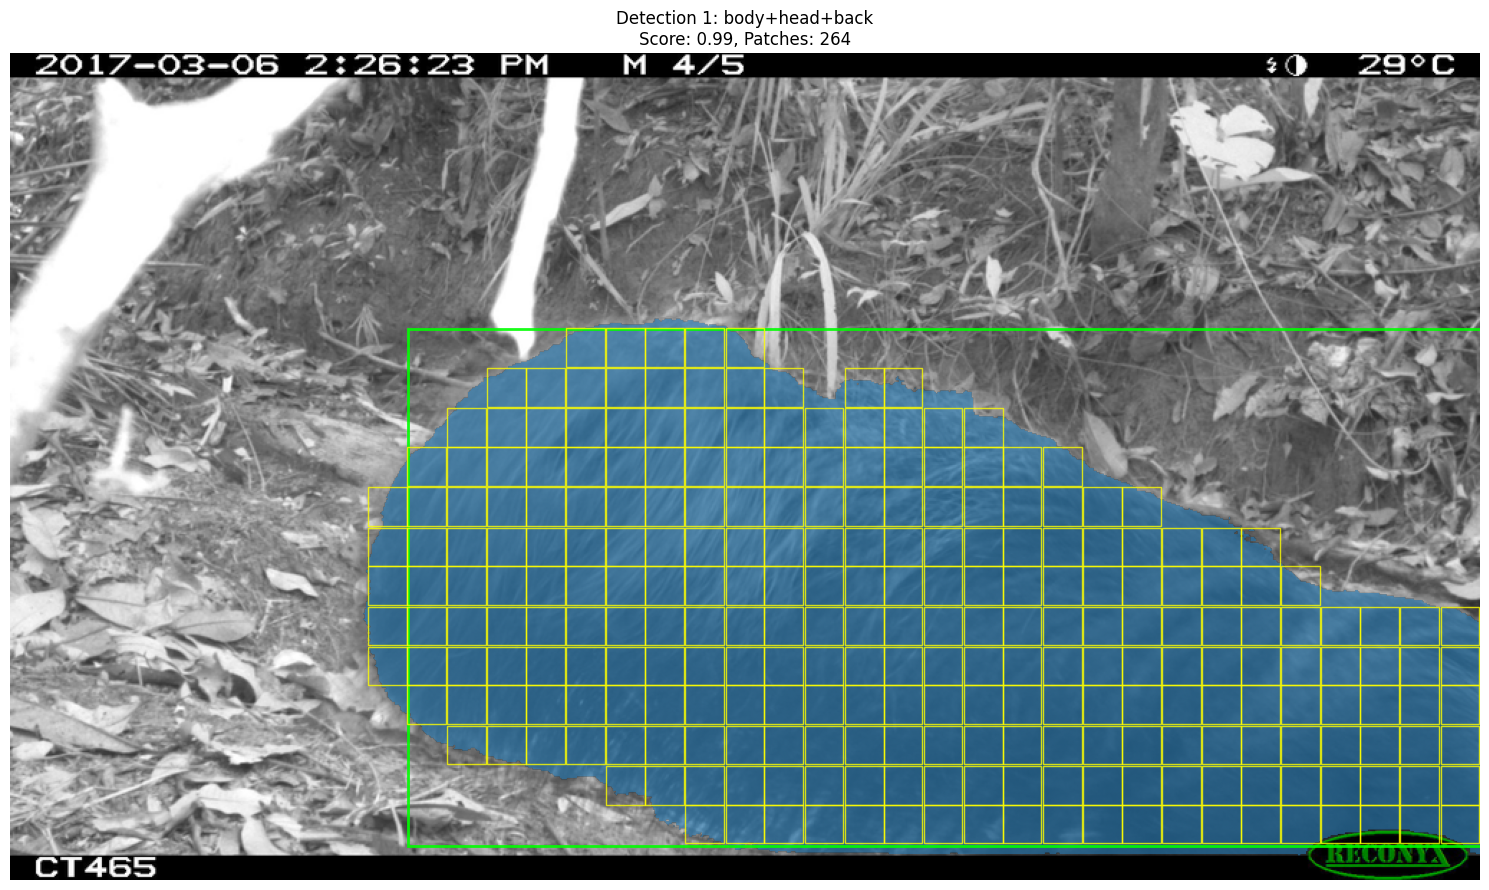

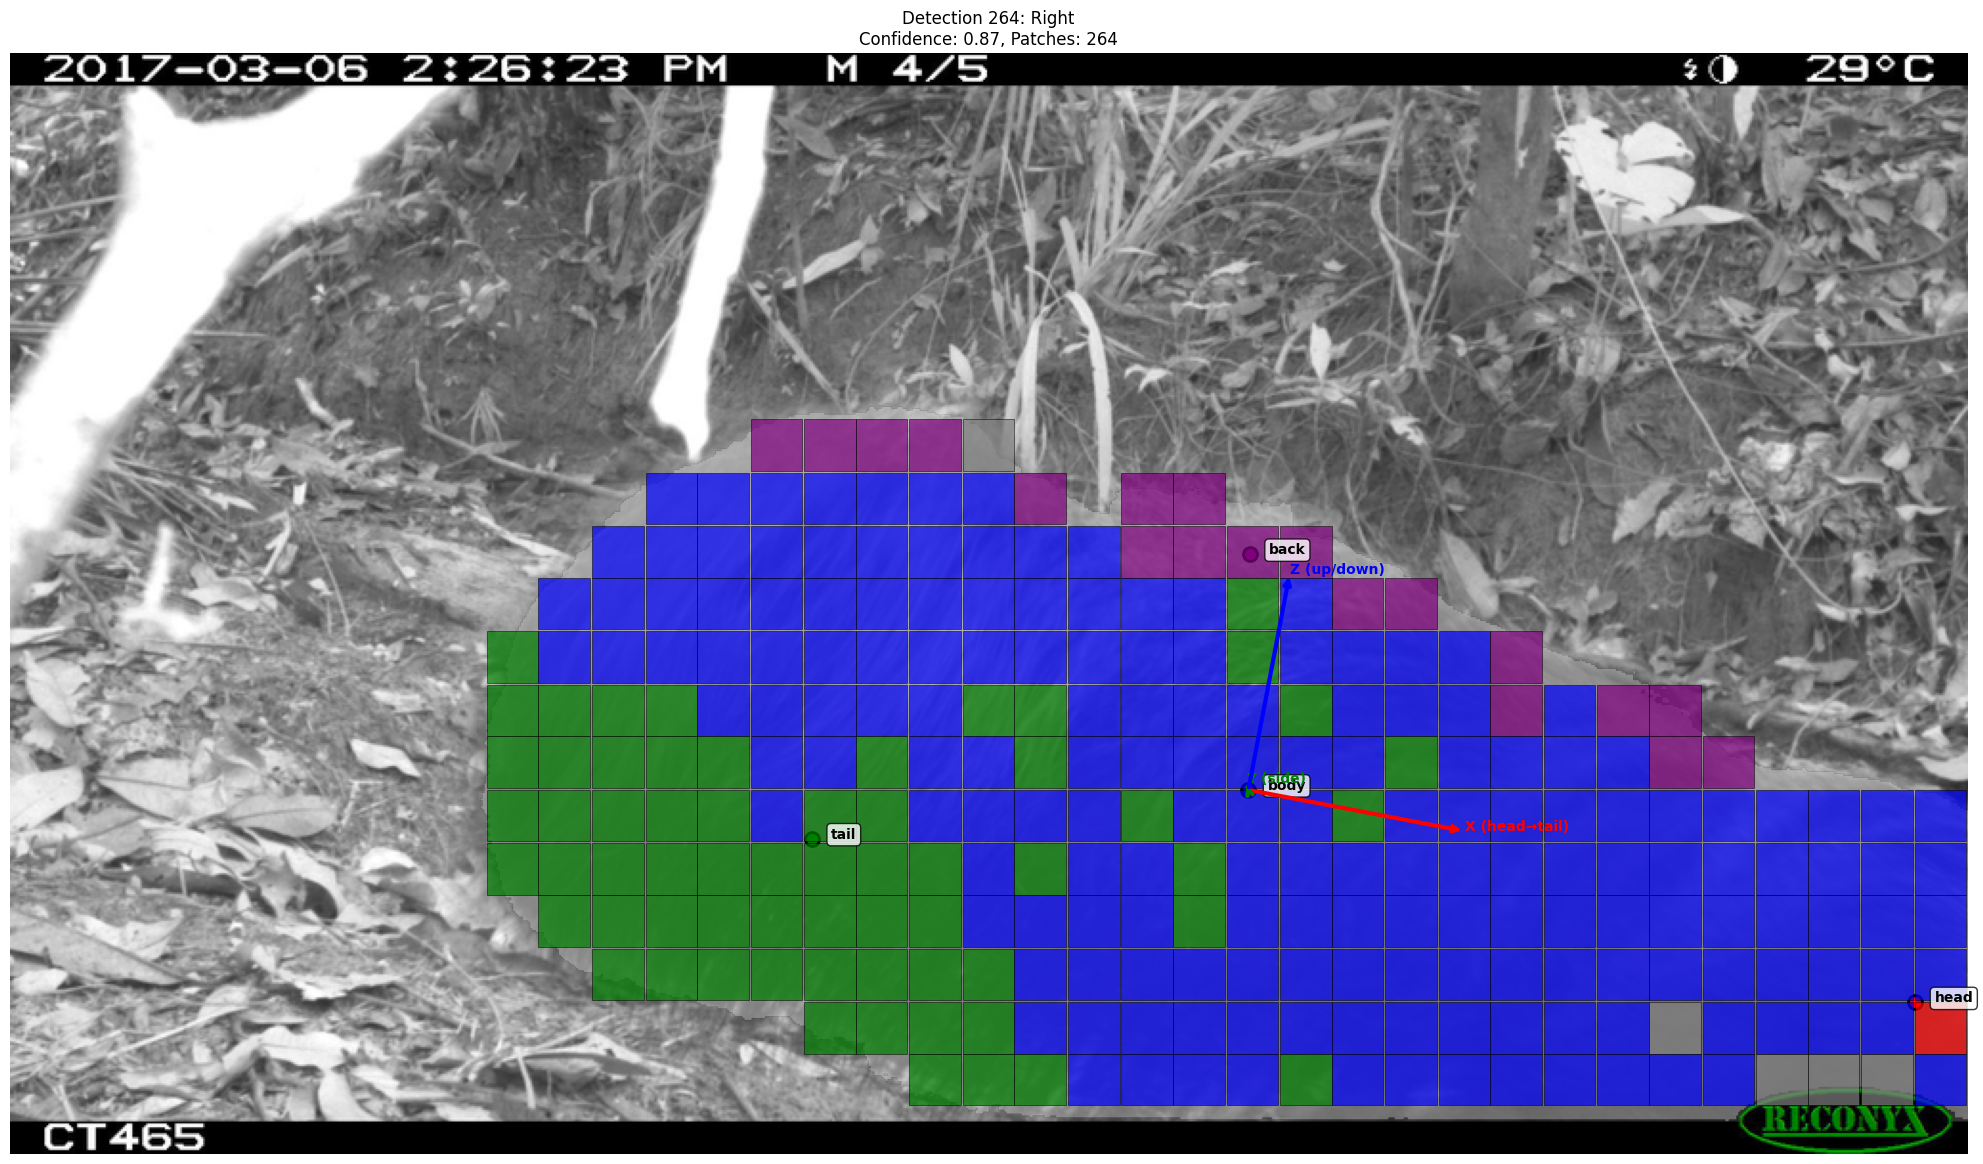

In [20]:
from src.detection.animal_detector import detect_animals_with_depth, detect_animals_with_sam2, get_body_part_bounding_box, get_detection_body_part_boxes, hierarchical_animal_detection
from src.classification.viewpoint_3d import estimate_viewpoint_for_detections
from src.visualization.detection_visualization import visualize_detection_viewpoints, visualize_sam2_detections
from PIL import Image

# annotations_filtered = [ann for ann in annotations if ann.category=='zebra_plains']

# annotation = annotations_filtered[15]
annotation = annotations[15]
# annotation = [a for a in annotations if "CT185-465_IMG_0835.JPG" in str(a.image_path)]
# image = Image.open("../../CT185-465_IMG_0835.JPG")
image = loader.load_image(annotation)
# image = detection_results[1]['image']
# image = Image.open("/fs/ess/PAS2136/ggr_data/kate/beluga/images/test2022/images/test0001.jpg")

detections, info = pipeline.process(image)

fig1 = visualize_sam2_detections(
      image=image,
      detections=detections,
      patch_coordinates=info["patch_coordinates"],
      relative_patch_size=info["relative_patch_size"],
      show_patches=True
  )
plt.show()

fig2 = visualize_detection_viewpoints(
    image=image,
    detections_with_viewpoints=detections,
    patch_components=info["patch_components"],
    patch_coordinates=info["patch_coordinates"],
    cluster_labels=info["cluster_labels"],
    relative_patch_size=info["relative_patch_size"],
    image_resize=1024,
)
plt.show()

In [20]:
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:

for annotation in annotations:
    image = loader.load_image(annotation)
    detections, info = pipeline.process(image)